In [2]:
import warnings
warnings.filterwarnings('ignore')
import argparse
import numpy as np
import networkx as nx
#import node2vec
from gensim.models import Word2Vec
import random

In [11]:

def read_graph(input,weighted,directed):
    '''
    Reads the input network in networkx.
    '''
    # 权重图
    if weighted:
        G = nx.read_edgelist(input, nodetype=int, data=(('weight', float),), create_using=nx.DiGraph())
    # 无权图
    else:
        G = nx.read_edgelist(input, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1
    # 无向操作
    if not directed:
        G = G.to_undirected()

    return G

In [14]:
nx_G = read_graph('../Graph/karate.edgelist',False,False)

In [16]:
print (len(nx_G))


34


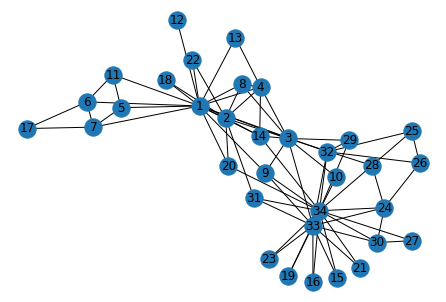

In [18]:
import matplotlib.pyplot as plt
nx.draw(nx_G, with_labels=True)
plt.show()

## 实现alias-sampling

In [19]:

class Graph():
    # 出事化设置参数
    def __init__(self, nx_G, is_directed, p, q):
        self.G = nx_G
        self.is_directed = is_directed
        self.p = p
        self.q = q
    
    
    def node2vec_walk(self, walk_length, start_node):
        '''
        Simulate a random walk starting from start node.
        '''
        G = self.G
        # 上一步计算出的alias table，完成O(1)的采样
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        #  直到生成长度为walk_length的节点序列位为止
        while len(walk) < walk_length:
            cur = walk[-1]
            # 对邻居节点排序，目的是和alias table计算时的顺序对应起来
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                # 节点序列只有一个节点的情况
                if len(walk) == 1:
                    # 直接使用alias——node对应的结果
                    walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                # 节点序列大于一个节点的情况
                else:
                    # 看前一个节点,prev是论文中的节点t
                    prev = walk[-2]
                    next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0],
                        alias_edges[(prev, cur)][1])]
                    walk.append(next)
            else:
                break

        return walk

    def simulate_walks(self, num_walks, walk_length):
        '''
        Repeatedly simulate random walks from each node.
        '''
        G = self.G
        walks = []
        nodes = list(G.nodes())
        print ('Walk iteration:')
        for walk_iter in range(num_walks):
            print (str(walk_iter+1), '/', str(num_walks))
            # 打乱节点顺序
            random.shuffle(nodes)
            for node in nodes:
                # node2vec_walk是一次有偏的随机游走
                walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

        return walks

    def get_alias_edge(self, src, dst):
        '''
        Get the alias edge setup lists for a given edge.
        '''
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        # 论文3.2.2节核心算法
        for dst_nbr in sorted(G.neighbors(dst)):
            if dst_nbr == src:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(G[dst][dst_nbr]['weight'])
            else:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
        
        # 归一化
        norm_const = sum(unnormalized_probs)
        normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        '''
        Preprocessing of transition probabilities for guiding the random walks.
        '''
        G = self.G
        is_directed = self.is_directed

        alias_nodes = {}
        # 节点概率alias sampling和归一化
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)
            # 信息展示
            if node == 2:
                print (unnormalized_probs)
                print (norm_const)
                print (normalized_probs)
                print (alias_nodes[node])

        alias_edges = {}
        triads = {}
        
        # 边概率alias sampling和归一化
        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])
        
        print ('edges alias')
        print (alias_edges[(2, 3)])
        
        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return


In [20]:
p = 1
q= 1
directed = False
G = Graph(nx_G, directed, p, q)


In [ ]:

def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    # 总过K个长度
    K = len(probs)
    # q个0
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = []
    larger = []
    
    # 将各个概率分成两组，一组的概率值大于1，另一组的概率值小于1
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)
    
    # 使用贪心算法，将概率值小于1的不断填满
    # pseudo code step 3
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        # 更新概率值
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

In [37]:

def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    # 取自己 
    if np.random.rand() < q[kk]:
        return kk
    # 取alias table存的节点
    else:
        return J[kk]


In [26]:
G.preprocess_transition_probs()


[1, 1, 1, 1, 1, 1, 1, 1, 1]
9
[0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]
(array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1.]))
edges alias
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))


In [27]:
num_walks = 10
walk_length = 20
# 有偏的随机游走生成节点序列
walks = G.simulate_walks(num_walks, walk_length)
# 展示一个节点序列的长度
print (len(walks[0]))

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
20


## 训练embedding

In [30]:
def learn_embeddings(walks,dimensions,window_size,workers,iter):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    # 将node的类型int转化为string
    # walks = [map(str, walk) for walk in walks]
    walk_lol = []
    for walk in walks:
        tmp = []
        for node in walk:
            tmp.append(str(node))
        walk_lol.append(tmp)
    # 调用gensim包运行word2vec
    model = Word2Vec(walk_lol, size=dimensions, window=window_size, min_count=0, sg=1, workers=workers,
                     iter=iter)
    # model.save_word2vec_format(args.output)
    # 保存embedding信息
#     model.wv.save_word2vec_format(args.output)

    return model


In [31]:
model = learn_embeddings(walks,16,3,-1,10)
print ('finished')

finished


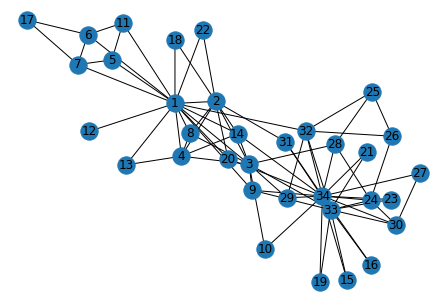

In [32]:
import matplotlib.pyplot as plt
nx.draw(nx_G, with_labels=True)
plt.show()

In [33]:
# # 找到和节点最相似的一组点
print (model.wv.most_similar('34'))

[('13', 0.5235618352890015), ('19', 0.49223029613494873), ('14', 0.3246092200279236), ('24', 0.3212704360485077), ('7', 0.2405083179473877), ('17', 0.1881570816040039), ('18', 0.18654769659042358), ('8', 0.14304210245609283), ('20', 0.12013332545757294), ('1', 0.11858232319355011)]


In [34]:

from scipy import spatial
def cos_similarity(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

# # 相似节点组1
print (cos_similarity(model['17'], model['6']))
print (cos_similarity(model['7'], model['6']))
print (cos_similarity(model['7'], model['5']))


# # 相似节点组2
# print (cos_similarity(model['34'], model['33']))
# print (cos_similarity(model['34'], model['9']))
# print (cos_similarity(model['34'], model['31']))

# # 不相似节点组
# print (cos_similarity(model['17'], model['25']))
# print (cos_similarity(model['7'], model['25']))


0.25079986453056335
0.1598823219537735
-0.2073010802268982


In [35]:

# k-means聚类
from sklearn import  cluster
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
import pandas as pd
embedding_node=[]
for i in range(1,35):
    j=str(i)
    embedding_node.append(model[j])
embedding_node=np.matrix(embedding_node).reshape((34,-1))
y_pred = cluster.KMeans(n_clusters=3, random_state=9).fit_predict(embedding_node) # 调用 test_RandomForestClassifier
y_pred



array([2, 1, 0, 1, 1, 1, 1, 0, 1, 2, 2, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       2, 1, 2, 2, 2, 2, 1, 2, 0, 0, 0, 1], dtype=int32)

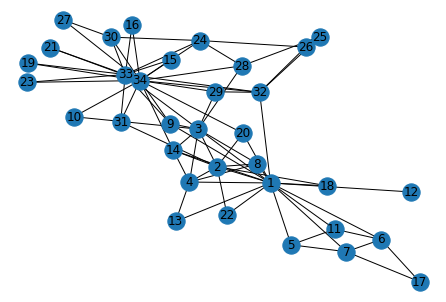

In [36]:

import matplotlib.pyplot as plt
nx.draw(nx_G, with_labels=True)
plt.show()
